In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Self-made packages
import pipelines.rookie_pipes as rp


Note: Every random state is used is from random.randint to maintain randomness.  It will be explicitly written though, to maintain reproducibility

In [2]:
df = pd.read_csv(os.path.join('..', 'data', 'rookies_stats.csv'))
stats_desc = pd.read_csv(os.path.join('..', 'data', 'rookies_stats_desc.csv'), index_col='feature')

df.head()

,rk,player,debut,age,yrs,g,mp,fg,fga,threes,...,pts,fg_pct,threes_pct,ft_pct,mp_pg,pts_pg,trb_pg,ast_pg,yr1,retired
0,1,Rafer Alston,"Feb 17, '00, MIL vs. IND",23,11,27,361,27,95,3,...,60,0.284,0.214,0.750,13.4,2.2,0.9,2.6,2000,1
1,2,Chucky Atkins,"Nov 2, '99, ORL @ CHH",25,11,82,1626,314,741,57,...,782,0.424,0.350,0.729,19.8,9.5,1.5,3.7,2000,1
2,3,William Avery,"Nov 13, '99, MIN vs. PHO",20,3,59,484,56,181,18,...,154,0.309,0.286,0.667,8.2,2.6,0.7,1.5,2000,1
3,4,Jonathan Bender,"Dec 10, '99, IND vs. CLE",19,8,24,130,23,70,2,...,64,0.329,0.167,0.667,5.4,2.7,0.9,0.1,2000,1
4,5,Calvin Booth,"Mar 25, '00, WAS @ DAL",23,10,11,143,16,46,0,...,42,0.348,0.000,0.714,13.0,3.8,2.9,0.6,2000,1


In [3]:
def get_desc(feature):
    '''This method takes a feature name and returns its description'''
    print(f"{feature}: {stats_desc['description'][feature]}")

## Notes:
- Drop:
    - 'fga' is redundant with the use of the made shots and the percentage.  This should be dropped
    - 'threes_a' is redundant with the use of the made shots and the percentage.  This should be dropped
    - 'fta' is redundant with the use of the made shots and the percentage.  This should be dropped
    - 'pts' is redundant with the use of all of the point stats.  This should be dropped
    - 'mp_pg' is redundant because we have games played and this stat cumulative.  This should be dropped
    - 'pts_pg' is redundant because we have games played and this stat cumulative.  This should be dropped
    - 'trb_pg' is redundant because we have games played and this stat cumulative.  This should be dropped
    - 'ast_pg' is redundant because we have games played and this stat cumulative.  This should be dropped
    - 'yr1' is useful info, just to know when they started, but it's not useful information for determining if someone will have a career of at least 5 years.  This should be dropped
    - 'retired' is important to consider when looking at players that have not yet hit a 5 year career.  This should be dropped
- Clean:
    - 'debut' is their first game.  We could see if the month their debut has any impact, but I doubt it would be important.  We can check anyways.  Order the months by start to end of season, not calendar
    - 'yrs' is the number of seasons they have played.  This is basically a label ( >/< 5 yrs).  It needs to be turned into the label we need
    - Another thing to do is scaling the values.  I would want to explore the data before scaling though
- Other:
    - 'player' is just their name.  We should not have it in any analyses, but we want to hold on to it, in case we want to know their names

In [4]:
drop_cols = ['fga', 'threes_a', 'fta', 'pts', 'mp_pg', 'pts_pg', 'trb_pg', 'ast_pg', 'yr1', 'retired']
min_seasons = 5

cleaning_pipe = Pipeline([
    ("drop_columns", rp.DropColumns(drop_cols)),
    ("get_month", rp.GetDebutMonth()),
    ("create_labels", rp.CreateLabels(min_seasons))
])

In [5]:
df_prepped = cleaning_pipe.fit_transform(df)
df_prepped.head()

,rk,player,debut,age,g,mp,fg,threes,ft,orb,trb,ast,stl,blk,tov,pf,fg_pct,threes_pct,ft_pct,lasts
0,1,Rafer Alston,4,23,27,361,27,3,3,5,23,70,12,0,29,29,0.284,0.214,0.750,True
1,2,Chucky Atkins,1,25,82,1626,314,57,97,20,126,306,52,3,142,137,0.424,0.350,0.729,True
2,3,William Avery,1,20,59,484,56,18,24,8,40,88,14,2,42,60,0.309,0.286,0.667,False
3,4,Jonathan Bender,2,19,24,130,23,2,16,4,21,3,1,5,7,18,0.329,0.167,0.667,True
4,5,Calvin Booth,5,23,11,143,16,0,10,15,32,7,3,14,6,23,0.348,0.000,0.714,True


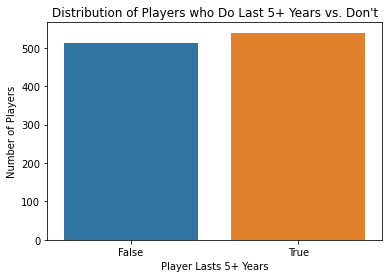

In [6]:
sns.countplot(data=df_prepped, x='lasts')
plt.title("Distribution of Players who Do Last 5+ Years vs. Don't")
plt.xlabel('Player Lasts 5+ Years')
plt.ylabel('Number of Players')
plt.show()

This is pretty evenly distributed.  This shows that there is a very high attrition rate in the NBA, but for our purposes, this means that we will not have to worry about poor distribution of class labels.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(df_prepped.drop('lasts', axis=1), df_prepped['lasts'], test_size=.3, random_state=56)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=.5, random_state=92)

I'm doing this here to prevent data snooping.  I want to ensure that I don't introduce my own bias

In [8]:
rookies = X_train.merge(y_train, on=X_train.index).drop('key_0', axis=1).join(df['yrs'], on=X_train.index)
rookies.head()

,rk,player,debut,age,g,mp,fg,threes,ft,orb,...,ast,stl,blk,tov,pf,fg_pct,threes_pct,ft_pct,lasts,yrs
0,48,Gal Mekel,0,25,31,292,30,5,8,5,...,63,4,1,31,31,0.349,0.25,0.667,False,2
1,4,Lou Amundson,4,24,11,89,6,0,4,13,...,1,1,8,5,15,0.400,0.00,0.400,True,10
2,64,Greg Stiemsma,2,26,55,766,66,0,29,48,...,28,37,85,33,144,0.545,0.00,0.707,False,4
3,11,Joe Crawford,6,22,2,23,3,1,2,1,...,1,1,0,0,2,0.300,0.25,1.000,False,1
4,54,Miles Plumlee,1,24,14,55,5,0,3,12,...,2,0,3,3,5,0.238,0.00,0.750,True,7


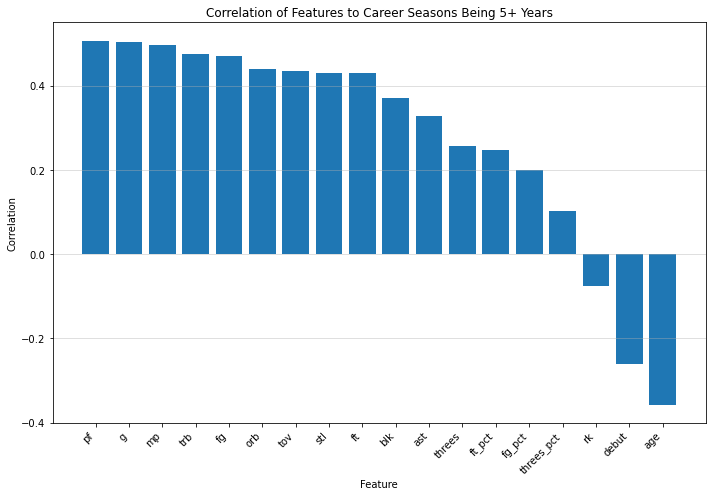

In [80]:
corrs = pd.DataFrame(rookies.corr()['lasts'].sort_values(ascending=False)).drop(['lasts', 'yrs'], axis=0).reset_index()

plt.figure(figsize=(10, 7))
plt.bar(data=corrs, x='index', height='lasts')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Correlation of Features to Career Seasons Being 5+ Years')
plt.ylabel('Correlation')
plt.xlabel('Feature')
plt.grid(axis='y', alpha=.5)
plt.tight_layout()
plt.show()

This has some really interesting information in it:
- A couple features have very weak correlations with if the player will last at least 5 years.
    - The player's rank has very little correlation with if the player will last at least 5 years.
        - This is not surprising, because this rank is based off of their performance in the NCAA, which is a totally different animal than the NBA.  Also, a team may have a specific need (position) at the moment that they're more interested in filling rather than just trying to get the very best player (any position).
    - The player's three point percentage is also a very weak correlator with the amount of time the player will stay in the NBA.
        - This makes sense because three pointers are the hardest shots to make, so the mentality for three pointers is more to take them and get rebounds to try again than for you to always make the shot
        - Secondly, multiple positions on the court are not really supposed to be taking shots from beyond the arc.  Your forward should be under the net, so of course he won't be taking three pointers as often, and probably won't have as high a percentage as others who should be taking threes.
- There are no strong correlations, but many of these features have correlations that are meaningful.
    - If a player is playing a lot of games, this means that the team finds him valuable enough to be playing.  This of course would mean that the player is less likely to leave the NBA in less than 5 years.
        - This is the same logic for minutes played.
        - Rebounds, field goals, free throws, and steals are all the actual skills that would lead to extra game time.  These are all skills that all successful players should have.
    - The negative correlation with age does not surprise me at all.  Players are considered old in the league at a very young age, so the younger you are the longer you can play before you are getting too 'old'
- There were two meaningful correlations that surprised me.
    - The positive correlation with personal fouls surprised me, because I would have thought that it implied carelessness during plays, can lead to giving the opponent free throws, and you can get fouled out.  However, after thinking about it there are some reasons why this does make sense:
        - Sometimes you want to foul the other team (particularly at the end of a close game)
        - If you're fouling, it implies that you're playing enough to foul, so part of this is carried in the minutes played as well I think
    - The positive correlation of turnovers surprised me, because this is distinctly negative (you're literally giving the other team the ball). However:
        - This could also be a carry over from minutes played, because players always will make mistakes, so even though it's a bad thing, it seems good because they have more of them.
        - This isn't typically a terrible mistake.  There are so many possessions in a game, and typically one possession doesn't make or break a game.  Also, turnovers are fairly common (probably due to so many possessions in a game), so it's not so terrible.
- I was surprised that the field goal percentage was not more highly correlated.  These are free points and shouldn't be wasted.  However, I suspect it's just that there are certain players that are the ones that are especially good at it, and the ones that aren't just don't handle the ball at the end of a close game.  Also, like the turnovers, I supposed that the one - three points that could be made from the free throws aren't critical in a 100+ point game.

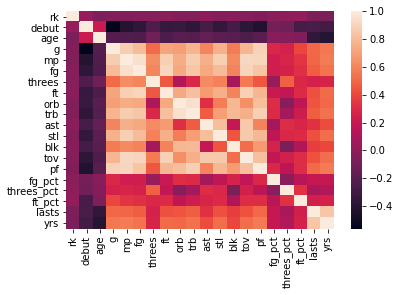

In [20]:
sns.heatmap(rookies.corr())
plt.show()

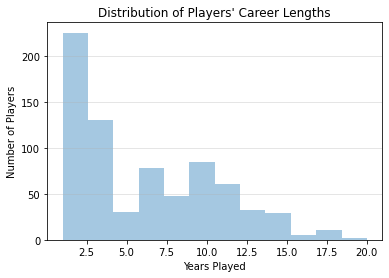

In [85]:
sns.distplot(rookies['yrs'], kde=False)
plt.title("Distribution of Players' Career Lengths")
plt.xlabel('Years Played')
plt.ylabel('Number of Players')
plt.grid(axis='y', alpha=.4)
plt.show()

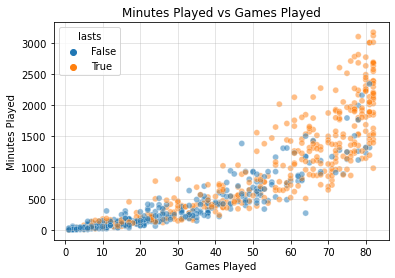

In [83]:
sns.scatterplot(data=rookies, x='g', y='mp', alpha=.5, hue='lasts')
plt.title('Minutes Played vs Games Played')
plt.xlabel('Games Played')
plt.ylabel('Minutes Played')
plt.grid(alpha=.4)
plt.show()

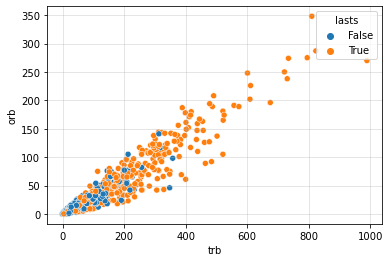

In [84]:
sns.scatterplot(data=rookies, x='trb', y='orb', hue='lasts')
plt.grid(alpha=.4)
plt.show()

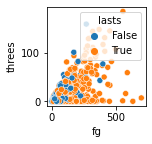

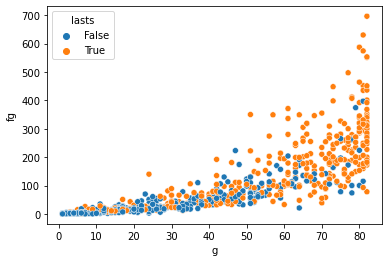

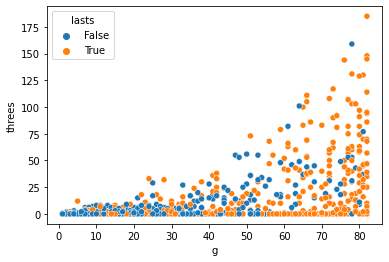

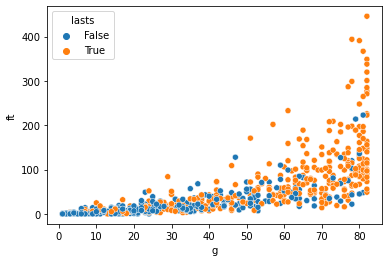

In [87]:
plt.subplot(2, 3, 1)
sns.scatterplot(data=rookies, x='fg', y='threes', hue='lasts')
plt.show()
sns.scatterplot(data=rookies, x='g', y='fg', hue='lasts')
plt.show()
sns.scatterplot(data=rookies, x='g', y='threes', hue='lasts')
plt.show()
sns.scatterplot(data=rookies, x='g', y='ft', hue='lasts')
plt.show()